In [ ]:
Instructions
1. Change Subject Code in first cell, Select this cell and run "Run all below selected cell"
2. Allow program to fully run then SAVE THE FILE
3. # Run these commands to get HTML File of Report 
export SUBJECT = subject code
jupyter nbconvert --to html --no-input RepFR_report.ipynb --output $SUBJECT\_repfr2_report.html


In [130]:
import cmlreaders as cml
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings; warnings.simplefilter('ignore')
pd.options.display.max_columns=None
pd.options.display.max_rows=100
from IPython.display import display, Markdown, HTML
import pandas_to_pybeh as pb
import matplotlib.ticker as mticker
import time
import glob
from tqdm import tqdm_notebook as lol
import repfr_crps as rcrp
from plotting import *

In [131]:
data = cml.get_data_index(kind = 'r1'); data = data[data['experiment'] == 'RepFR2']
# print("Size of Dataset:")
# print(len(data), 'sessions')
# print(len(data['subject'].unique()), 'subjects')
# print(data['subject'].unique())
# data[['subject', 'session']].groupby('subject').agg('count').rename(columns={'session':'# of sessions'})
# data

In [132]:
subject = 'R1579T'
# session = 0
exp = 'RepFR2'
localization = 0
montage = 0

In [133]:
display(
    Markdown(
        '# '+ subject + ' RepFR2 Report'
    )
)

# R1579T RepFR2 Report

In [134]:
evs = []
data = cml.get_data_index(kind = 'r1'); data = data[data['experiment'] == 'RepFR2']; data = data[data['subject'] == subject]
for session in pd.unique(data['session']):
    r = cml.CMLReader(subject=subject, experiment='RepFR2', session=session, localization=localization, montage=montage)
    temp = r.load('task_events')
    evs.append(temp)
evs = pd.concat(evs)
evs.reset_index(inplace=True)
evs.drop(['index'], inplace=True, axis = 1)
word_evs = evs[evs.type=='WORD']
rec_evs = evs[evs.phase=='retrieval']


In [157]:
import os
import json
# pd.set_option('display.max_rows', None)
log_dir = '/data10/RAM/subjects/' + subject +'/behavioral/' + exp + '/*/session.jsonl'
log_dir_list = glob.glob(log_dir)
heart_beat = []
jsonl = []
for log_dir in log_dir_list:
    for i, char in enumerate(log_dir):
        if(char == '_'):
            sess = (log_dir[i+1])
            break

    with open(log_dir, 'r') as fr:
        lines = fr.readlines()
        for line in lines:
            try:
                jsonl.append(json.loads(line))
            except Exception as e:
                continue       
    temp = pd.DataFrame(jsonl)
    temp['session'] = pd.Series(int(sess), index = temp.index)
    heart_beat.append(temp)

heart_beat = pd.concat(heart_beat)

heart_beat['message'] = heart_beat.data.apply(lambda x: dict.get(x, 'message'))
heart_beat.dropna(inplace=True)
heart_beat['type'] = heart_beat.message.apply(lambda x: dict.get(x, 'type'))
heart_beat['data'] = heart_beat.message.apply(lambda x: dict.get(x, 'data'))
heart_beat = heart_beat[heart_beat.type.isin(['HEARTBEAT', 'HEARTBEAT_OK'])]
heart_beat['count'] = heart_beat.data.apply(lambda x: dict.get(x, 'count'))
heart_beat = heart_beat[heart_beat['count'] > 20]


Minimum Latency: 0.69, Maximum Latency: 230.94
Tenth Percentile Latency: 0.97, Ninetieth Percentile Latency: 10.03


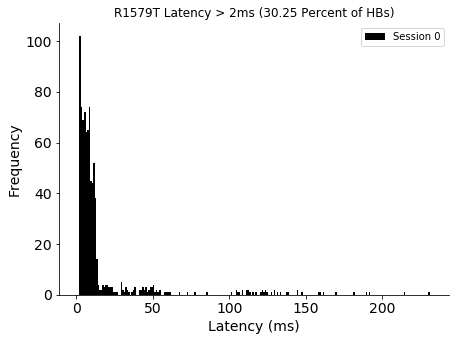

In [153]:
for sess, df in heart_beat.groupby('session'):    
    bpm_sent = pd.DataFrame()
    bpm_done = pd.DataFrame()
    bpm_sent = df[df.type == 'HEARTBEAT']
    
    bpm_sent.drop_duplicates('count', inplace = True, keep = 'first')

    bpm_done = df[df.type == 'HEARTBEAT_OK']
    bpm_done.drop_duplicates('count', inplace = True, keep = 'first')
    bpm_done.set_index('count', inplace = True)
    bpm_sent.set_index('count', inplace = True)
    bpm_err = bpm_done.time.astype(float) - bpm_sent.time.astype(float)
    bpm_err = bpm_err[bpm_err.index > 20]
    _max = round(bpm_err.max(), 2)
    _min = round(bpm_err.min(), 2)
    ten = round(bpm_err.quantile(.10), 2)
    ninety = round(bpm_err.quantile(.90), 2)
    print('Minimum Latency:', str(_min) + ',', 'Maximum Latency:', _max)
    print('Tenth Percentile Latency:', str(ten)+',', 'Ninetieth Percentile Latency:', ninety)
    
    norm = bpm_err[bpm_err<2].count()
    bpm_err = bpm_err[bpm_err > 2]
    no_norm = bpm_err[bpm_err > 2].count()
    percent = no_norm/(norm+no_norm) * 100
    percent = round(percent, 2)
        
    set_axes(figsize = (7, 5))
    _max = int(round(bpm_err.max()))

    bins = range(_max+2)
    bpm_err.plot.hist(bins = bins, label = 'Session ' + str(sess), color = 'black')
    plt.legend()
    plt.title(subject + ' Latency > 2ms (' + str(percent)+ ' Percent of HBs)')
    plt.xlabel('Latency (ms)')
#     plt.text(bpm_err.max())
# plt.savefig('latency/'+subject+'latency_unfilt.pdf')
# non_zero = np.where(bpm_err != 0)[0]
# non_zero_err = bpm_err.iloc[non_zero]
# # non_zero_err.plot.hist()
# non_zero_err[non_zero_err['Time Discrepancy'] > 100]
# bpm_done[bpm_done['time'] > 1e13]

In [ ]:
# where = bpm_err.reset_index()['count'].to_numpy()
# bad = beh
# # events[~events.type.str.contains('HEART')]
# bad['data'] = bad.message.apply(lambda x: dict.get(x, 'data'))
# bad['count'] = bad.data.apply(lambda x: dict.get(x, 'count'))
# indeces = bad[bad['count'].isin(where)].index - 1
# b4_bad = bad[bad.index.isin(indeces)]
# b4_bad.query('type != "HEARTBEAT"', inplace = True)
# b4_bad.groupby('type')['data'].count().reset_index().rename(columns={'data' : 'count'}).set_index('type')


In [ ]:
sess = evs.loc[evs['list'] != -999]
sess = sess.loc[sess['type'] == 'WORD']
sessions = sess.groupby('session')['list'].unique()
sess_codes = []
for sess in sessions.index:
    sess_codes.append(subject+':'+exp+':'+str(sess))

ddays = []
for sess in sessions:
    ddays.append(len(sess))

timestamp = evs.groupby('session').mstime.first()/1000
dates = []
for sec in timestamp:
    dates.append(time.strftime('%Y-%m-%d', time.localtime(sec)))

minutes = round((evs.groupby('session').mstime.last() - evs.groupby('session').mstime.first())/1000/60, 2)
minutes = minutes.reset_index()

sessions = pd.DataFrame()
sessions['Session Code'] = pd.Series(sess_codes)
sessions['Date'] = pd.Series(dates)
sessions['Length [min]'] =  minutes['mstime']

sessions['Lists'] = pd.Series(ddays)
total_lists = sessions.Lists.sum()

sessions = sessions.style.hide_index()
sessions

In [ ]:
rec_evs = []
for i, df in evs.groupby('list'):
    words = df[df.type == 'WORD'].item_num.unique()
    rec_df = df[df.type == 'REC_WORD']
    rec_df['correct'] = pd.Series(False, rec_df.index)
    correct = rec_df[rec_df.item_num.isin(words)].index
    for j in correct:
        rec_df.loc[j, 'correct'] = True
    rec_evs.append(rec_df)
rec_evs = pd.concat(rec_evs)
np.where(evs.index.duplicated() == True)


In [1]:
wanted = ['REC_START', 'REC_END', 'STIM', 'REC_WORD']
rec_ind = rec_evs.index
evs.loc[rec_ind, 'correct'] = rec_evs['correct']
stim = evs[evs.type.isin(wanted)]
stim = stim[stim.phase != 'encoding']
rec_stim = []
no_rec_stim = []
for i, df in stim.groupby(['session', 'list']):
    if('STIM' in df.type.unique()):
        df['rec_time'] = df.mstime - df.mstime.iloc[0]
        rec_stim.append(df)
    else:
        df['rec_time'] = df.mstime - df.mstime.iloc[0]
        no_rec_stim.append(df)
rec_stim = pd.concat(rec_stim)
no_rec_stim = pd.concat(no_rec_stim)
rec_stim = rec_stim[rec_stim.type =='REC_WORD']
rec_stim = rec_stim[rec_stim.correct == True]
no_rec_stim = no_rec_stim[no_rec_stim.type == 'REC_WORD']
no_rec_stim = no_rec_stim[no_rec_stim.correct == True]

# rec_stim
# FOR ACTUAL STIM TIMES USE THIS CODE
# # rec_stim = rec_stim[rec_stim.type.isin(['REC_WORD', 'STIM'])]
# count = 0

# split_times = []
# times = []
# for i, df in rec_stim.iterrows():
#     if df.type == 'STIM':
#         stim_time = df.rec_time
#         if times:
#             times.pop(0)
#             if times:
#                 split_times.append(times)
#         times = []
    
#     times.append(df.rec_time - stim_time)
# split_times = [j for sub in split_times for j in sub]
# rec_stim



NameError: name 'rec_evs' is not defined

In [ ]:
def get_normed_times(i, value):
    if i < value:
        return i
    else:
        i = i - value
        return get_normed_times(i, value)
    

In [ ]:
# FOR BINNING BASED JUST ON 3750 ms INTERVALS USE THIS CODE
rec_times = rec_stim.rec_time.to_numpy()
no_times = no_rec_stim.rec_time.to_numpy()
stim_times = []
sham_times = []
for i in rec_times:
    stim_times.append(get_normed_times(i, 3750))
    
for i in no_times:
    sham_times.append(get_normed_times(i, 3750))
xti = np.arange(11)*375
stim_digi= np.digitize(stim_times, xti)
sham_digi= np.digitize(sham_times, xti)


stim_counts = np.zeros(11)
sham_counts = np.zeros(11)

for i in stim_digi:
    stim_counts[i] += 1

for i in sham_digi:
    sham_counts[i] += 1




In [ ]:
set_axes(figsize = (8, 5), xticks = xti, ylim = [-10, 25])
_ = plt.ylabel('Number of Correct Recalls', fontsize = 14)
_ = plt.xlabel('Time (ms)', fontsize = 14)
_ = plt.axhline(y=0, color='black', linestyle='--')

_ = plt.axvspan(0, 750, alpha=0.2, color='yellow', label = 'Stimulation Period')

n = plt.hist((stim_times, sham_times), bins = xti, color = ['deepskyblue', 'orange'], cumulative=True, histtype = 'bar', label = ['Stim', 'No Stim'])
# n = plt.hist(sham_times, bins = xti, color = ['navy'], cumulative=True, histtype = 'bar', label = ['No Stim'], alpha = 0.5,)


# _ = ax2.hist(sham_times, bins = xti, label = 'No Stim', color = 'navy', cumulative=True)
# plt.title("Recalls As Function of Time Binned by Stim Period (" + subject+ ")", fontsize=18)
diff = stim_counts - sham_counts
diff = pd.Series(diff, index=xti-187.5)
diff = diff.drop(-187.5)
diff = diff.cumsum()
# _ = plt.bar(diff.index, diff.values, width =375, edgecolor = 'black', label = 'Difference', color = 'green', alpha = 0.5)
_ = plt.plot(diff.index, diff.values, label = 'Cumulative Difference', color = 'black', linestyle = '--', marker='o')
_ = plt.legend()


# plt.bar(height = stim_digi, x = xti)
plt.savefig(subject+'_bin_stim_cum')

### Charts

In [ ]:
trecall = word_evs.groupby(['session', 'list', 'is_stim'])['recalled'].mean().reset_index()
trecall = trecall.groupby(['session', 'is_stim'])['recalled'].mean().reset_index()
trecall = trecall['recalled'].mean() * 100
pd.set_option('display.max_rows', None)
# word_evs.loc[word_evs.stim_list != word_evs.is_stim]

In [ ]:

recalled = pd.DataFrame(columns = ['Repeats', 'Recall Rate (%)'])
recalled['Recall Rate (%)'] = word_evs.groupby(['repeats', 'is_stim'])['recalled'].mean() * 100
recalled = recalled.reset_index()
recalled['Repeats'] = recalled['repeats']
# recalled = recalled.drop('repeats', axis = 1)
# total = pd.DataFrame()
# total['Repeats'] = pd.Series('Total Recall')
# total['Recall Rate (%)'] = pd.Series(trecall)
# recalled = recalled.append(total).reset_index().drop('index', axis = 1)
# plt.hist(recalled['Repeats'])
# plt.plot(recalled)
# recalled = recalled.set_index(['is_stim', 'Repeats'])



# recalled.plot.bary = 'Recall Rate (%)')
# recalled.drop('Repeats', 1).plot.bar()
# fig, ax = plt.subplots(figsize=(10, 9))

recalled = recalled.reset_index().drop('repeats',1)


In [ ]:
stim = []
nostim = []
stim_lists = []
nostim_lists = []
for i, df in rec_evs.groupby('list'):
    if(np.isin('STIM', df.type.unique())):
        stim.append(df)
        stim_lists.append(i)
    else:
        nostim.append(df)
        nostim_lists.append(i)

nostim = pd.concat(nostim)
stim_rec = pd.DataFrame()

stim = word_evs.loc[word_evs['list'].isin(stim_lists)]
nostim = word_evs.loc[word_evs['list'].isin(nostim_lists)]
nostim['stimulation'] = pd.Series(False, index = nostim.index)
stim['stimulation'] = pd.Series(True, index = stim.index)

rec_stim = stim.append(nostim)
# set_axes(figsize = (7, 7))
fig, ax = plt.subplots(1,2, figsize = (14, 7))
_ = plt.ylim([0, 1])
_ = ax[0].set_ylim([0, 1])
# g = sns.barplot(data = stim, x = 'repeats', y = 'recalled', color = '')

g = sns.barplot(ax=ax[0], data = rec_stim, x = 'repeats', y = 'recalled', hue = 'stimulation', palette = ['deepskyblue', 'orange'],
           ci=95, capsize = .05, errwidth=2)
_ = ax[0].set_title('Retrieval Stimulation Recall Effect', fontsize = 14)
_ = ax[0].set_xlabel('Number of Presentations', fontsize = 13)
_ = ax[0].set_ylabel('Recall Proportion', fontsize = 14)
_ = ax[0].legend(title = 'Stimulation')
_ = ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize = 14)
_ = ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize = 14)
_ = ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize = 14)
_ = ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize = 14)
# fig.ylim[0, 1]
# set_axes(figsize = (7, 7))


g = sns.barplot(ax = ax[1], data = word_evs, x = 'repeats', y = 'recalled', hue = 'is_stim', palette = ['deepskyblue', 'orange'],
               ci=95, capsize = .05, errwidth=2)
_ = plt.title('Encoding Stimulation Recall Effect', fontsize = 16)
_ = plt.xlabel('Number of Presentations', fontsize = 14)
_ = plt.ylabel('Recall Proportion', fontsize = 14)
_ = plt.legend(title = 'Stimulation')
plt.show()

In [136]:
pd.get_dummies(rec_evs, columns=['repeats']).groupby('intrusion').agg('sum').iloc[:, -3:]

,repeats_1,repeats_2,repeats_3
intrusion,,,
-999,0,0,0
-1,0,0,2
0,13,39,82
1,1,2,3
2,1,0,0
3,0,1,0
10,1,0,0
13,0,1,0
15,1,0,0


### Plots

### Lag-CRP and Minimum Lag-CRP

In [139]:
crp = []
num_lags = 6
for j, df in evs.groupby('session'):
    rec_evs = df[df.type == 'REC_WORD'].reset_index()
    word_evs = df[df.type == 'WORD']
    recs = rcrp.get_act_spos(rec_evs, word_evs)
    sess_crps = rcrp.crp(recs, num_lags = num_lags, list_length = 27)
    sess_crp = sess_crps.groupby('lag').mean()
    crp.append(sess_crp)
crp = pd.concat(crp)
crp = crp.reset_index()
crp = crp.replace([np.inf, -np.inf], 0)



### Minimum Lag-CRP

In [140]:
min_crp = []
num_lags = 6
for j, df in evs.groupby('session'):
    rec_evs = df[df.type == 'REC_WORD'].reset_index()
    word_evs = df[df.type == 'WORD']
    recs = rcrp.get_act_spos(rec_evs, word_evs)
    sess_crps = rcrp.min_crp(recs, num_lags = num_lags, list_length = 27, halfornah = 'nah')
    sess_crp = sess_crps.groupby('lag').mean()
    min_crp.append(sess_crp)
min_crp = pd.concat(min_crp)
min_crp.reset_index(inplace = True)

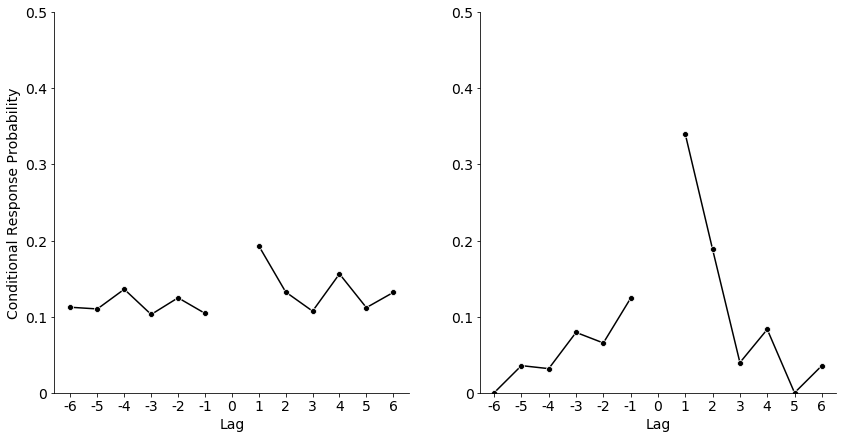

In [141]:
fig, ax = plt.subplots(1,2, figsize=(14, 7))
error_bars ={'elinewidth':2, 'capsize':3, 'capthick':2}
right_side = ax[0].spines["right"]
right_side.set_visible(False)
top_side = ax[0].spines["top"]
top_side.set_visible(False)
right_side = ax[1].spines["right"]
right_side.set_visible(False)
top_side = ax[1].spines["top"]
top_side.set_visible(False)

g = sns.lineplot(ax = ax[0], data = crp[crp.lag>0], x = 'lag', y = 'prob', err_style = 'bars', ci = 95, marker = 'o', color = 'black', err_kws=error_bars)
g = sns.lineplot(ax = ax[0], data = crp[crp.lag<0], x = 'lag', y = 'prob', err_style = 'bars', ci = 95, marker = 'o', color = 'black', err_kws=error_bars)


_ = ax[0].set_xticks(range(-num_lags, num_lags+1))

# _ = plt.grid()
_ = plt.xlim(-num_lags - 0.5, num_lags + 0.5)


# _ = plt.title('Massed Lag-CRP (Hospital RepFR1)', fontsize = 18)
_ = ax[0].set_ylabel('Conditional Response Probability', fontsize = 14)
_ = ax[0].set_xlabel('Lag', fontsize = 14)
_ = ax[0].set_ylim([0, 0.5])

error_bars ={'elinewidth':2, 'capsize':3, 'capthick':2}


g = sns.lineplot(ax = ax[1], data = min_crp[min_crp.lag > 0], x = 'lag', y = 'prob', err_style = 'bars', ci = 95, marker = 'o', color = 'black', err_kws=error_bars)
g = sns.lineplot(ax = ax[1], data = min_crp[min_crp.lag < 0], x = 'lag', y = 'prob', err_style = 'bars', ci = 95, marker = 'o', color = 'black', err_kws=error_bars)
_ = plt.xticks(range(-num_lags, num_lags+1))

# _ = plt.grid()
_ = plt.xlim(-num_lags - 0.5, num_lags + 0.5)

# _ = plt.title('Massed Lag-CRP (Hospital RepFR1)', fontsize = 18)
_ = plt.ylabel('', fontsize = 14)
_ = plt.xlabel('Lag', fontsize = 14)
_ = plt.ylim([0, 0.5])
_ = ax[0].set_xticklabels(range(-num_lags, num_lags+1), fontsize = 14)
_ = ax[0].set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5], fontsize = 14)
_ = ax[1].set_xticklabels(range(-num_lags, num_lags+1), fontsize = 14)
_ = ax[1].set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5], fontsize = 14)

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (14, 7))
ax[0].set_ylim([0, 1])
ax[1].set_ylim([0, 1])
sns.lineplot(ax=ax[0], data=word_evs.reset_index(), y='recalled', x='repeats', color='black',
             linestyle='--', err_style='bars', err_kws={'capsize':5}, ci=95)
ax[0].set_xticks(ticks=[1, 2, 3])
ax[0].set_xlabel('# of Repetitions', fontsize=16)
ax[0].set_ylabel('Probability of Recall', fontsize=16)

right_side = ax[0].spines["right"]
right_side.set_visible(False)
top_side = ax[0].spines["top"]
top_side.set_visible(False)

right_side = ax[1].spines["right"]
right_side.set_visible(False)
top_side = ax[1].spines["top"]
top_side.set_visible(False)

rec_evs['is_intrusion'] = (rec_evs.intrusion!=0).astype(int)
sns.lineplot(ax = ax[1], data=rec_evs[rec_evs.repeats>0].reset_index(), y='is_intrusion', x='repeats', color='black',
             linestyle='--', err_style='bars', err_kws={'capsize':5}, ci=95)
plt.xticks(ticks=[1, 2, 3])
plt.xlabel('# of Repetitions', fontsize=16)
plt.ylabel('Intrusion Rate', fontsize=16)


## EEG 

In [144]:
session = data['session'].unique()[0]

subject = 'R1579T'
print('Session ' + str(session))
data = cml.get_data_index(kind = 'r1'); data = data[data['experiment'] == 'RepFR2']; data = data[data['subject'] == subject]
r = cml.CMLReader(subject=subject, experiment='RepFR2', session=session, localization=localization, montage=montage)
evs = r.load('task_events')

word_evs = evs[evs.type=='WORD']
rec_evs = evs[evs.type=='REC_WORD']

Session 0


In [145]:
pairs = r.load('pairs')



In [146]:
word_evs['eegfile'].unique()

contacts = r.load('contacts')
buf = 500
eeg = r.load_eeg(word_evs, rel_start=-500 - buf, rel_stop=500 + buf, scheme=contacts)


In [147]:
eeg_ptsa = eeg.to_ptsa()
# Butterworth filter to remove 60 Hz line noise + harmonic at 120
eeg_ptsa = eeg_ptsa.filtered([58, 62])
eeg_ptsa = eeg_ptsa.filtered([118, 122])

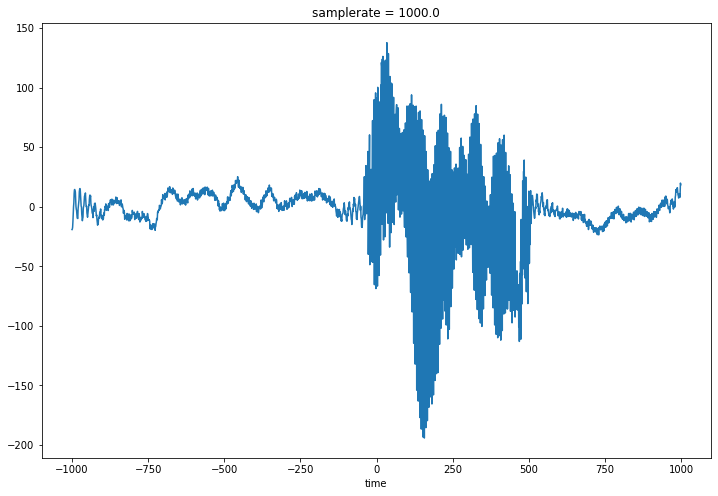

In [148]:
from ptsa.data.filters import MorletWaveletFilter

erp = eeg_ptsa[word_evs.recalled.astype(bool).values].mean(['event', 'channel']) - eeg_ptsa[~word_evs.recalled.astype(bool).values].mean(['event', 'channel'])

plt.figure(figsize=(12, 8))
e = erp.plot()

# pows = MorletWaveletFilter(timeseries=eeg_ptsa, freqs=np.logspace(np.log10(6), np.log10(180), 8), output='power', width=4, cpus=10).filter()

# pows = pows.remove_buffer(0.5)

# mask = word_evs.recalled.astype(bool).values
# sme = pows[:, mask].mean(['event', 'channel']) - pows[:, ~mask].mean(['event', 'channel'])

In [116]:
# fig = plt.figure(figsize=(20, 10))
# ax = plt.gca()
# im = ax.imshow(sme, cmap='coolwarm', aspect = 20, interpolation='hamming')
# plt.yticks(ticks = range(0, 8), labels=[f"{f:.0f}" for f in np.logspace(np.log10(6), np.log10(180), 8)])
# labels = ax.get_xticklabels()
# ax.tick_params(axis='x', labelsize=14)
# ax.tick_params(axis='y', labelsize=14)
# plt.xlabel('Time', fontsize=20)
# plt.ylabel('Frequencies', fontsize=20)
# plt.title('Subsequent Memory Effect', fontsize=24)
# cbar = plt.colorbar(im, ax=ax, fraction = .01)
# cbar.set_label(label='t statistic \n (remembered - forgotten)', size=16)
# cbar.ax.tick_params(labelsize=14)

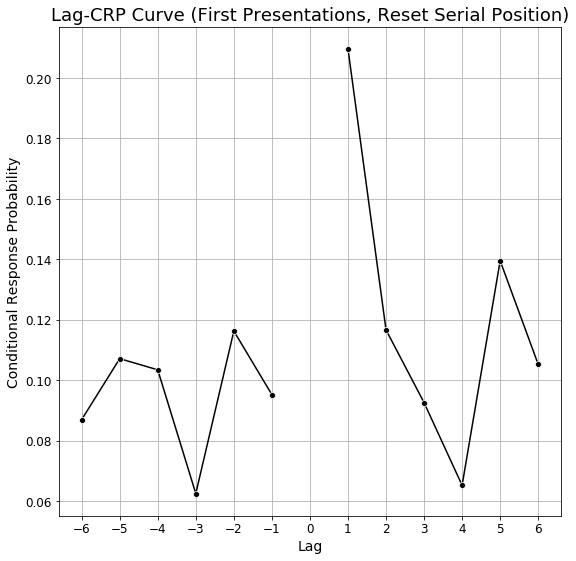

In [93]:
# crp = word_evs.query('is_repeat == False')
# fake_crp = []
# crp

# for i in range(total_lists):
#     for j in range(12):
#         fake_crp.append(j)
# fake_crp = pd.Series(fake_crp, index = crp.index)

# crp['serialpos'] = fake_crp
# beh = crp.append(rec_evs)
# agg = []
# for i, df in beh.groupby('session'):
#     agg.append(pb.pd_crp(df, itemno_column='item_num', list_index=['subject', 'session', 'list'], lag_num=6))

# crp_df = pb.pd_crp(beh, itemno_column='item_num', list_index=['subject', 'session', 'list'], lag_num=6)

# agg = pd.concat(agg)
# error_bars ={'elinewidth':1.5, 'capsize':3, 'capthick':1.5}
# _ = plt.figure(figsize=(9, 9))
# _ = plt.title('Lag-CRP Curve (First Presentations, Reset Serial Position)', fontsize = 18)
# _ = plt.xticks(range(-6, 7), fontsize = 12)
# _ = plt.yticks(fontsize = 12)
# _ = plt.grid()
# g = sns.lineplot(data=agg.loc[agg['lag'] < 0], x='lag', y='prob', err_style = 'bars', ci = 95, marker = 'o', color = 'black', err_kws=error_bars)
# g = sns.lineplot(data=agg.loc[agg['lag'] > 0], x='lag', y='prob', err_style = 'bars', ci = 95, marker = 'o', color = 'black', err_kws=error_bars)
# _ = plt.xlabel('Lag', fontsize = 14)
# _ = plt.ylabel('Conditional Response Probability', fontsize = 14)
